In [44]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import scipy
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, balanced_accuracy_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn import svm

X, Y = datasets.make_classification(n_samples=300, n_features=2, random_state=222720, n_redundant=0, n_classes=2, n_clusters_per_class=2, n_informative=2)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# train_X , test_X, train_Y, test_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=222720)
rng = np.random.default_rng()




In [45]:
# Funkcje jądra
class Kernel():
    def __init__(self) -> None:
        pass
    def __call__(self, A: np.ndarray, B: np.ndarray):
        raise NotImplementedError
    

# Linear Kernel

class LinearKernel(Kernel):
    def __init__(self) -> None:
        super().__init__()
    def __call__(self, A: np.ndarray, B: np.ndarray):
        return A.T @ B

# Poly Kernel

class PolyKernel(Kernel):
    def __init__(self, degree: int):
        super().__init__()
        self._degree = degree

    def __call__(self, A: np.ndarray, B: np.ndarray):
        return np.power(1 + A.T @ B, self._degree)
    

# Radial Kernel

class RadialKernel(Kernel):
    def __init__(self, gamma: float):
        super().__init__()
        self._gamma = gamma

    def __call__(self, A: np.ndarray, B: np.ndarray):
        dist_matrix = distance_matrix(A.T, B.T)
        return np.exp(-self._gamma * np.power(dist_matrix, 2))
    


In [46]:
class MYSVM:
    def __init__(self, kernel: Kernel, C: float = np.inf):
        self._kernel = kernel
        self.C = C
        self._lambdas = None
        self._suppX = None
        self._suppy = None

    def fit(self, X: np.ndarray, Y: np.ndarray):
        def svm_loss(
                lambdas: np.ndarray,
                X : np.ndarray,
                Y: np.ndarray,
                kernel : Kernel,
        ):
            Y = Y[:, np.newaxis]
            lambdas = lambdas[:, np.newaxis]

            loss = np.sum(lambdas) - 0.5 * np.sum((lambdas @ lambdas.T) * (Y @ Y.T) * kernel(X.T, X.T))
            return - loss
        self._lambdas = rng.random(Y.shape) + 1e-3
        res = minimize(
            svm_loss, self._lambdas, (X, Y, self._kernel),
        
            bounds = np.c_[np.zeros_like(self._lambdas), np.ones_like(self._lambdas) + self.C],
            constraints = [LinearConstraint(Y, 0, 0)],
            options = {'maxiter':1000, 'disp': True},
        )
        self._lambdas = np.round(res.x, 3)
        mask = self._lambdas > 0
        self._lambdas = self._lambdas[mask]
        self._suppX = X[mask]
        self._suppy = Y[mask]
        self._b = self._suppy - self.transform(self._suppX)
        self._b = sum(self._b) / len(self._b)

    def transform(self, X):
        if self._lambdas is None:
            raise ValueError
        
        return np.sum(self._lambdas * self._suppy * self._kernel(X.T, self._suppX.T), axis=1)
    
    def predict(self, X):
        return np.sign(self.transform(X) + self._b)


In [47]:
def eval_svm(kernel, X, Y, C=np.inf):
    Y = 1 - 2 * Y
    train_X = X
    test_X = X
    train_Y = Y
    test_Y = Y
    svm = MYSVM(kernel, C)
    svm.fit(train_X, train_Y)
    return test_Y, svm.predict(test_X), svm

y_true, y_pred, model = eval_svm(LinearKernel(), X, Y, 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -679.4708015243541
            Iterations: 56
            Function evaluations: 16857
            Gradient evaluations: 56


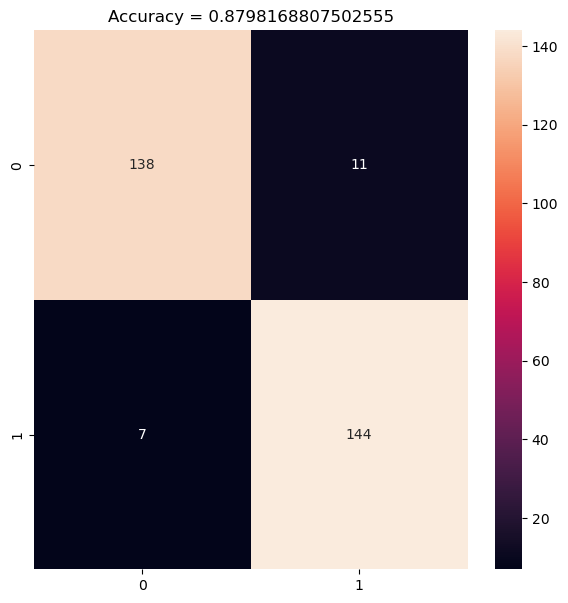

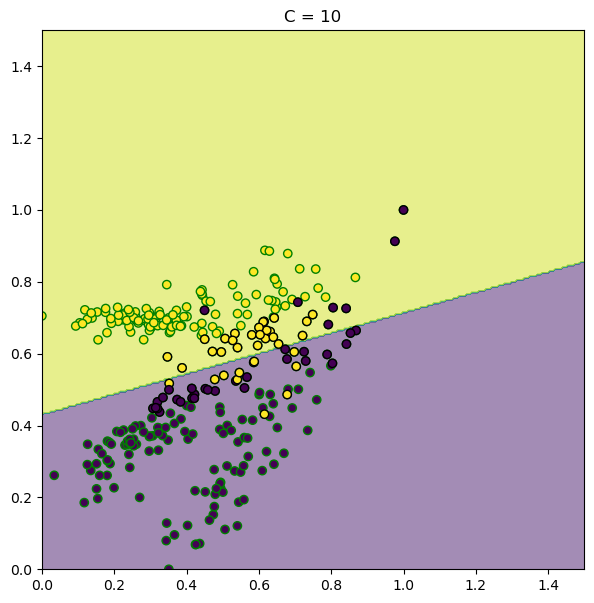

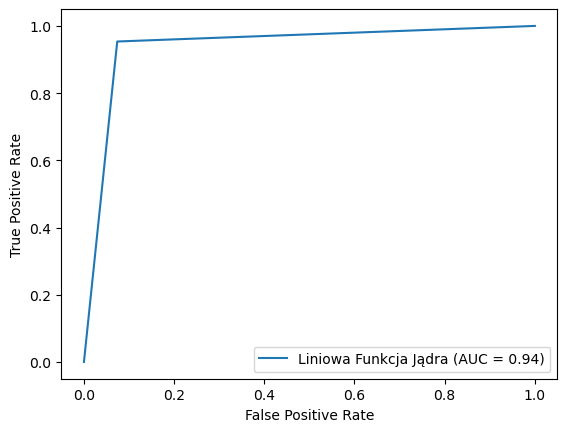

In [48]:
def plot_classifier(model, X: np.ndarray, Y: np.ndarray):
    x1 = np.linspace(1.5 * X[:, 0].min(), 1.5 * X[:, 0].max(), 300)
    x2 = np.linspace(1.5 * X[:, 1].min(), 1.5 * X[:, 1].max(), 300)
    xx, yy = np.meshgrid(x1, x2)
    XX = np.stack((xx.flatten(), yy.flatten())).T
    zz = model.predict(XX)
    zz = zz.reshape(xx.shape)

    plt.figure(figsize=(7, 7))
    plt.contourf(xx, yy, (1 - zz) // 2, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='green')
    plt.scatter(model._suppX[:, 0], model._suppX[:, 1], c=model._suppy < 0, edgecolors='black')
    plt.title(f'C = {model.C}')
    plt.show()

acc = balanced_accuracy_score(y_true, y_pred, adjusted=True)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

plot_classifier(model, X, Y)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()


In [60]:
sk_svm = svm.SVC(kernel='linear', C=100)
train_X , test_X, train_Y, test_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=222720)
model = sk_svm.fit(train_X, train_Y)
model_pred = model.predict(test_X)
model_pred
test_Y

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

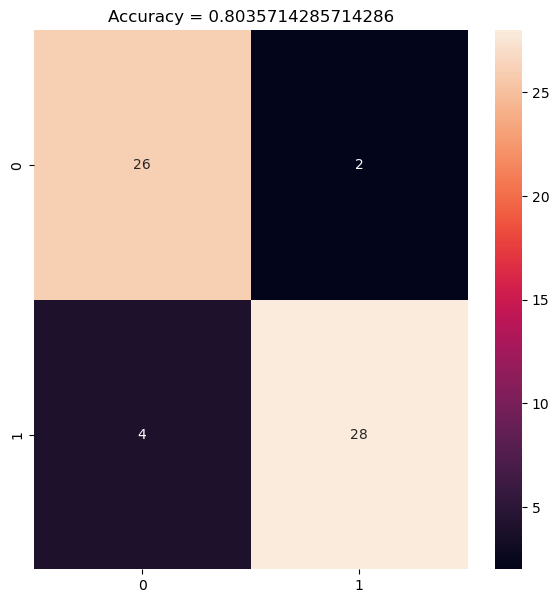

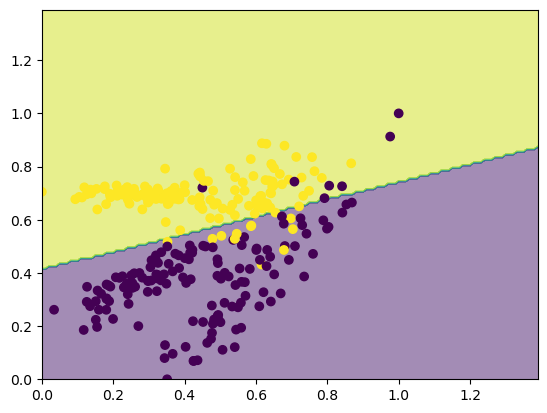

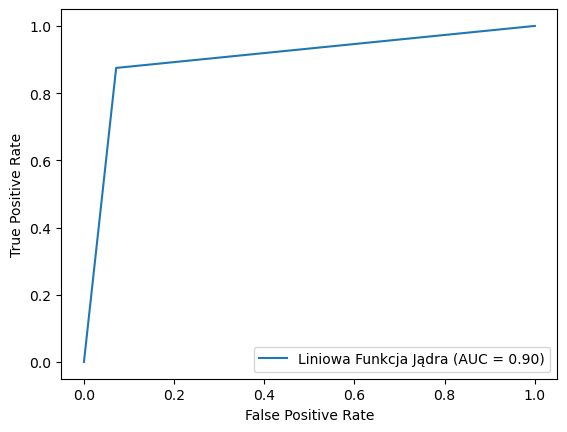

In [61]:
acc = balanced_accuracy_score(test_Y, model_pred, adjusted=True)
conf = confusion_matrix(test_Y, model_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

mesh = np.meshgrid(np.arange(0, 1.4, 0.01), np.arange(0, 1.4, 0.01))[0]
sk_mesh = model.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
plt.contourf(mesh, mesh.T, sk_mesh, alpha=0.5)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_Y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y)
fpr, tpr, thresholds = roc_curve(test_Y, model_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

In [51]:
y_true, y_pred, model = eval_svm(PolyKernel(4), X, Y, 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -408.39470965226883
            Iterations: 59
            Function evaluations: 17763
            Gradient evaluations: 59


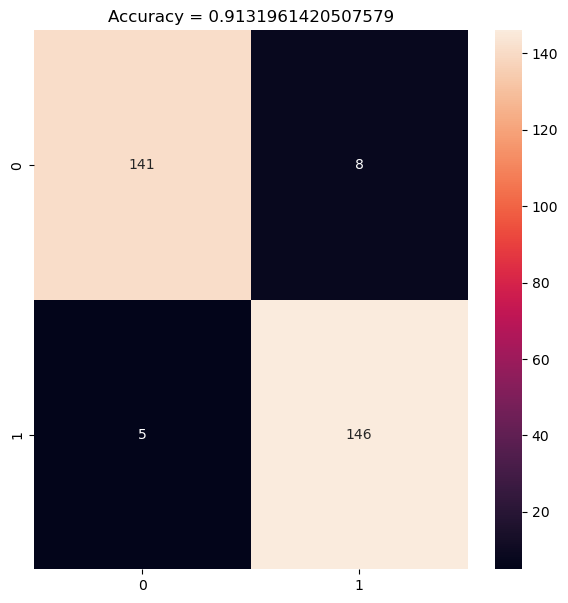

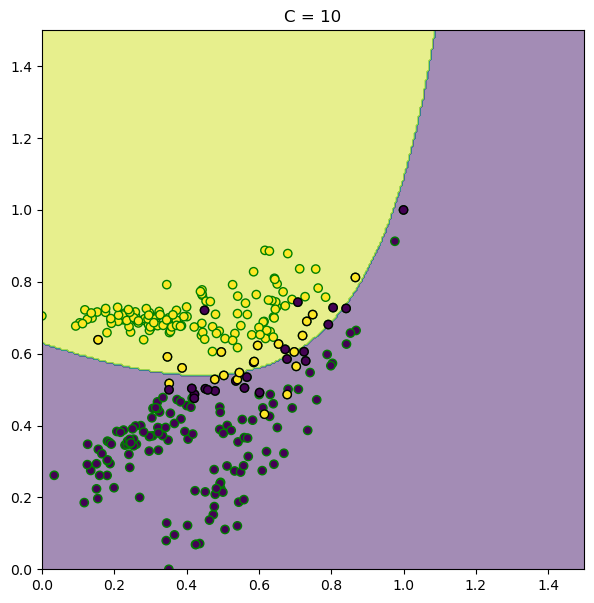

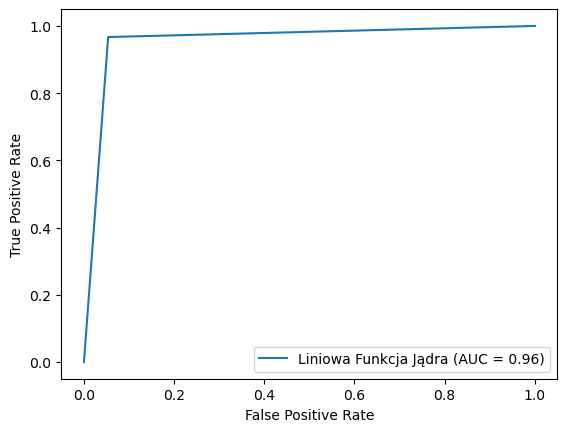

In [52]:
acc = balanced_accuracy_score(y_true, y_pred, adjusted=True)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

plot_classifier(model, X, Y)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

In [94]:
sk_svm = svm.SVC(kernel='poly', C=100, degree=5)
train_X , test_X, train_Y, test_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=222720)
model = sk_svm.fit(train_X, train_Y)
model_pred = model.predict(test_X)
model_pred
test_Y

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

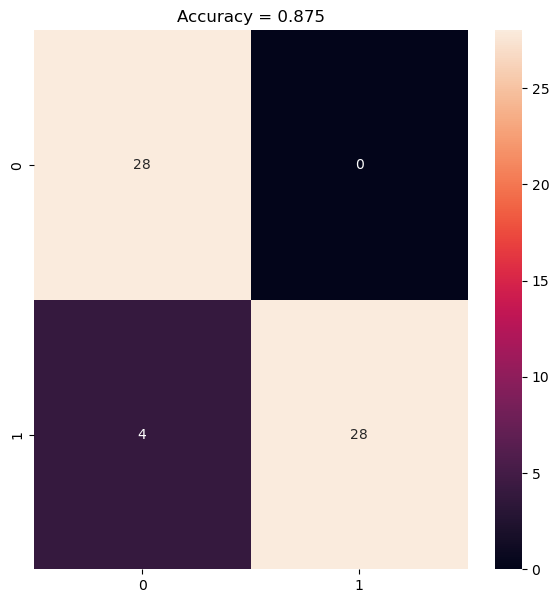

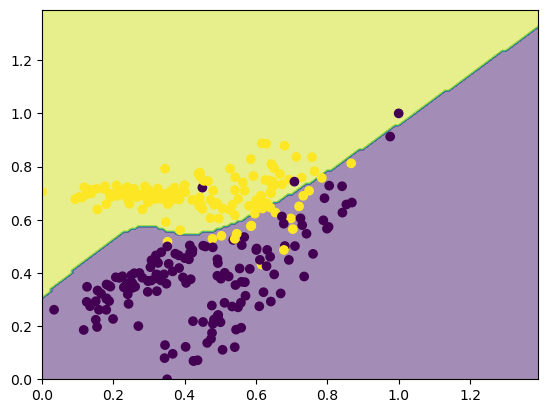

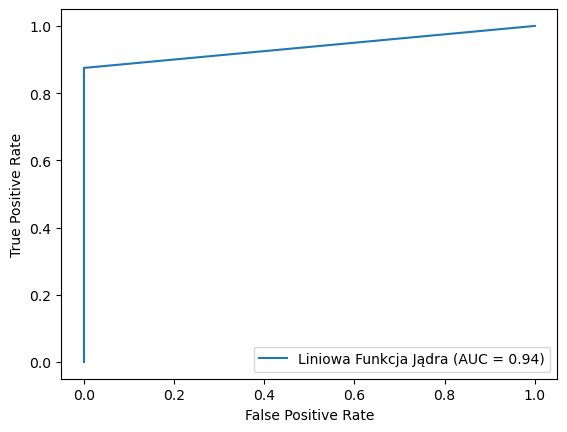

In [95]:
acc = balanced_accuracy_score(test_Y, model_pred, adjusted=True)
conf = confusion_matrix(test_Y, model_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

mesh = np.meshgrid(np.arange(0, 1.4, 0.01), np.arange(0, 1.4, 0.01))[0]
sk_mesh = model.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
plt.contourf(mesh, mesh.T, sk_mesh, alpha=0.5)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_Y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y)
fpr, tpr, thresholds = roc_curve(test_Y, model_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

In [55]:
y_true, y_pred, model = eval_svm(RadialKernel(gamma=10), X, Y, 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -363.8907621469921
            Iterations: 65
            Function evaluations: 19568
            Gradient evaluations: 65


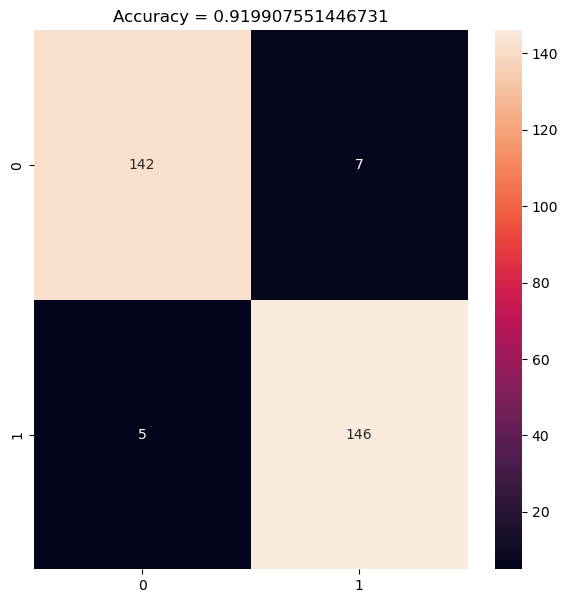

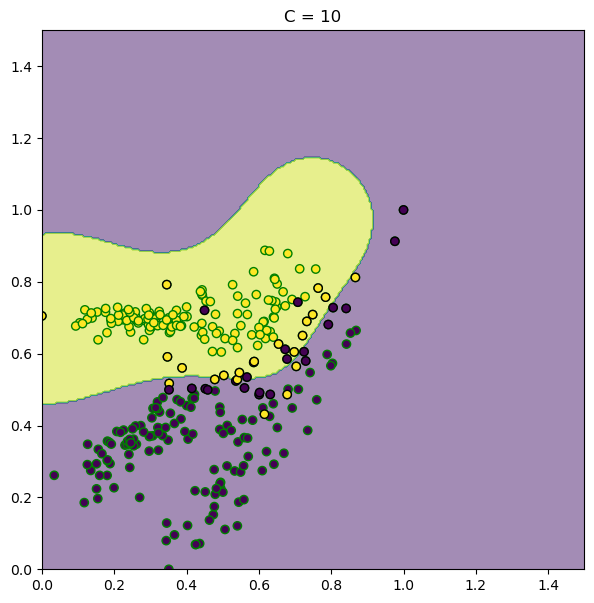

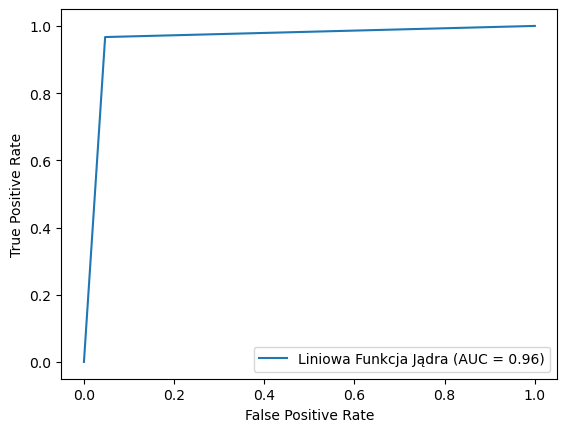

In [56]:
acc = balanced_accuracy_score(y_true, y_pred, adjusted=True)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

plot_classifier(model, X, Y)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

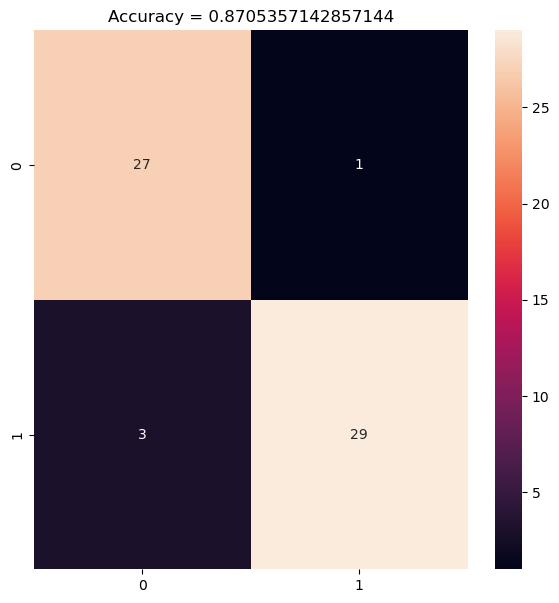

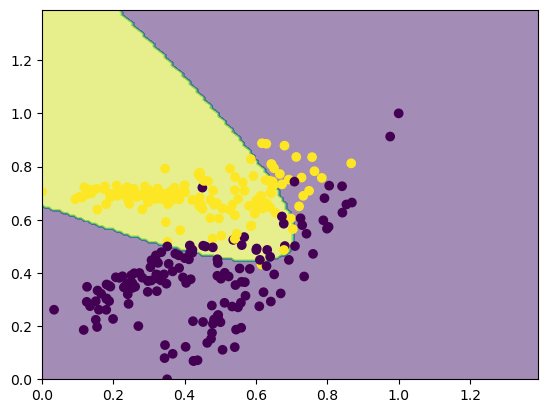

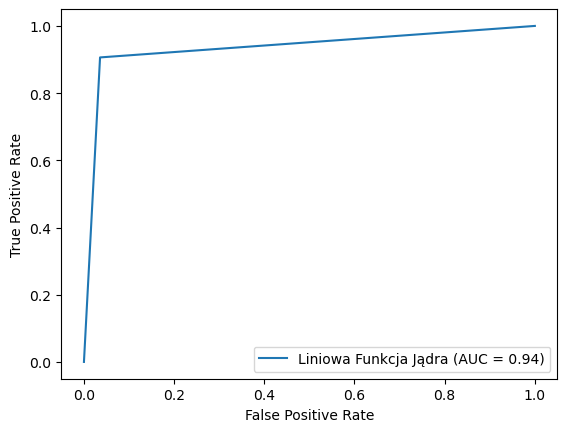

In [91]:
sk_svm = svm.SVC(kernel='sigmoid', C=1000, gamma=1,coef0=0.2)
train_X , test_X, train_Y, test_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=222720)
model = sk_svm.fit(train_X, train_Y)
model_pred = model.predict(test_X)
model_pred
test_Y

acc = balanced_accuracy_score(test_Y, model_pred, adjusted=True)
conf = confusion_matrix(test_Y, model_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

mesh = np.meshgrid(np.arange(0, 1.4, 0.01), np.arange(0, 1.4, 0.01))[0]
sk_mesh = model.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
plt.contourf(mesh, mesh.T, sk_mesh, alpha=0.5)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_Y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y)
fpr, tpr, thresholds = roc_curve(test_Y, model_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

In [96]:
moons_x, moons_y = datasets.make_moons(n_samples=300, noise = 0.1, random_state=222720)
moons_x = scaler.fit_transform(moons_x)

y_true, y_pred, model = eval_svm(PolyKernel(4), moons_x, moons_y, 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -609.2457042989623
            Iterations: 66
            Function evaluations: 19873
            Gradient evaluations: 66


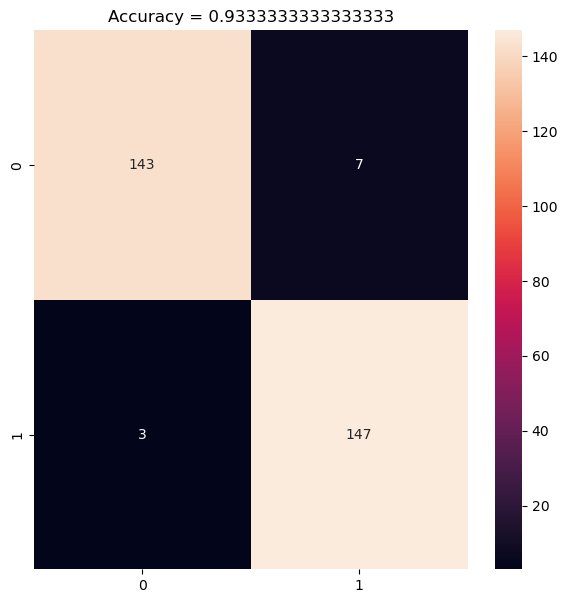

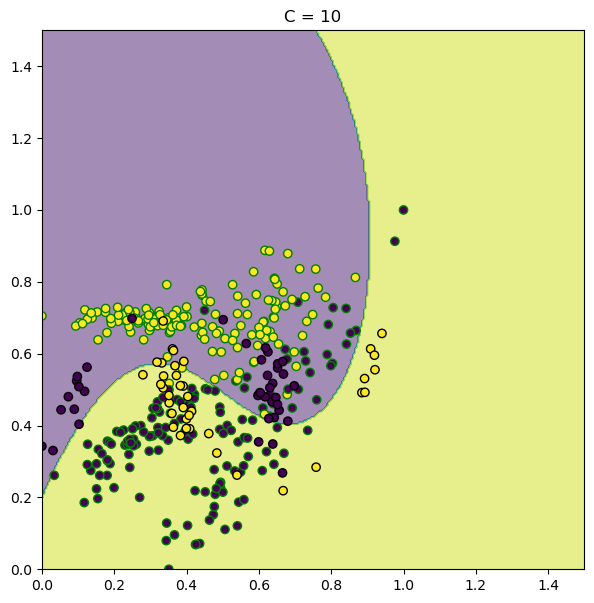

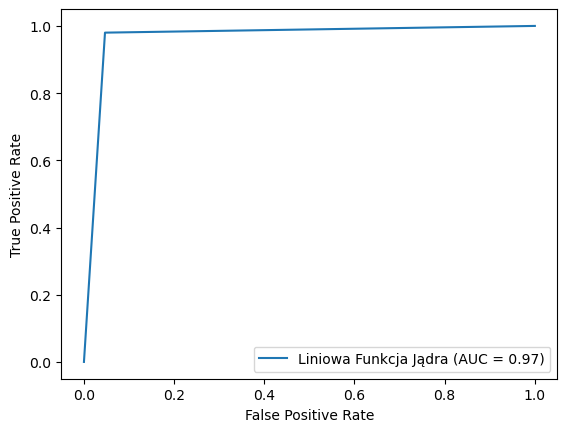

In [97]:
acc = balanced_accuracy_score(y_true, y_pred, adjusted=True)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

plot_classifier(model, X, Y)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()

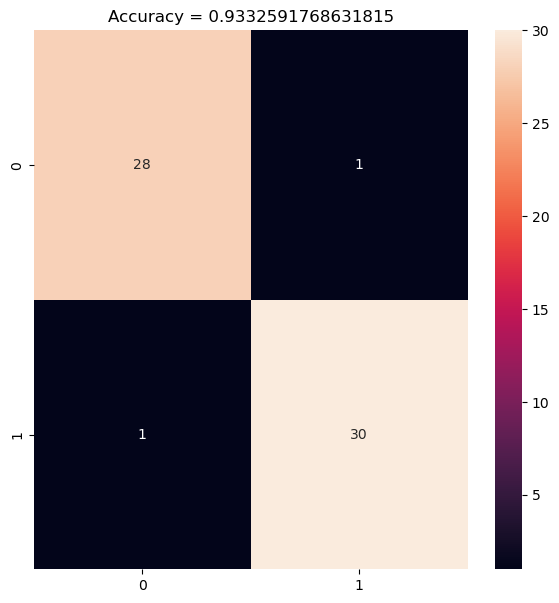

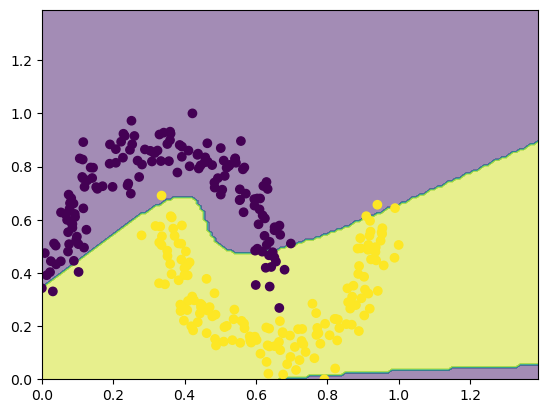

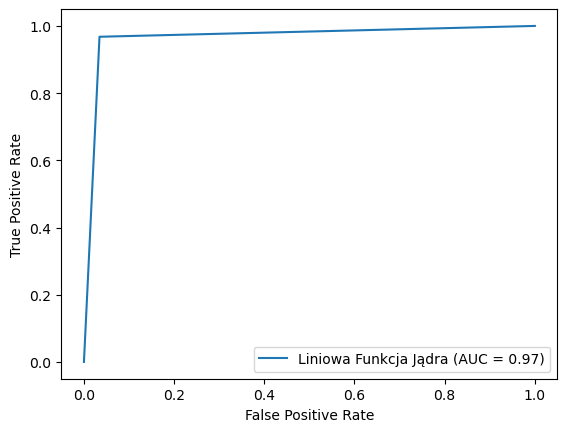

In [101]:
sk_svm = svm.SVC(kernel='poly', C=10, degree=4)
train_X , test_X, train_Y, test_Y = model_selection.train_test_split(moons_x, moons_y, test_size=0.2, random_state=222720)
model = sk_svm.fit(train_X, train_Y)
model_pred = model.predict(test_X)
model_pred
test_Y

acc = balanced_accuracy_score(test_Y, model_pred, adjusted=True)
conf = confusion_matrix(test_Y, model_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf, annot=True, fmt='d')
plt.title(f'Accuracy = {acc}')
plt.show()

mesh = np.meshgrid(np.arange(0, 1.4, 0.01), np.arange(0, 1.4, 0.01))[0]
sk_mesh = model.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
plt.contourf(mesh, mesh.T, sk_mesh, alpha=0.5)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_Y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y)
fpr, tpr, thresholds = roc_curve(test_Y, model_pred)
roc_auc = auc(fpr, tpr)
display_lin = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Liniowa Funkcja Jądra')
display_lin.plot()